In [1]:
import networkx as nx
import itertools
import more_itertools
import pandas
from IPython.display import display, SVG
import collections

pandas.set_option('display.max_columns', None)  # or 1000
pandas.set_option('display.max_rows', None)  # or 1000
pandas.set_option('display.max_colwidth', None)  # or 199

In [2]:
def draw(graph):
    svg = nx.nx_agraph.to_agraph(graph).draw(prog='dot',format='svg')
    display(SVG(svg))
    

In [3]:
oracles = nx.read_edgelist('oracles', create_using=nx.DiGraph, data=(('label', str),))
implications = nx.read_edgelist('implications', create_using=nx.DiGraph)

def closed_descendants(x):
    return {x} | nx.descendants(implications, x)

def closed_ancestors(x):
    return {x} | nx.ancestors(implications, x)

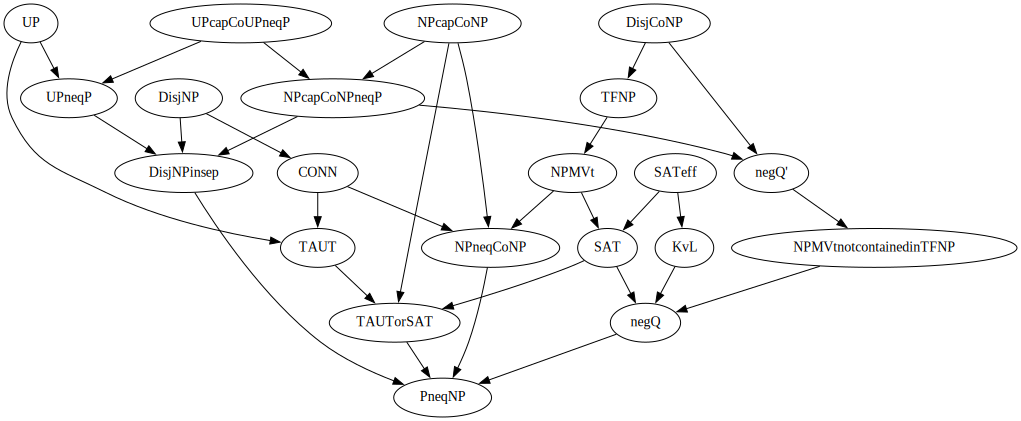

In [4]:
draw(implications)

In [5]:
oracle_set = set()
oracle_set_labels = collections.defaultdict(list)

for (a, b) in oracles.edges:
    if b in nx.descendants(implications, a):
        print(a,b)
    
    s = set(itertools.product({a} | nx.descendants(implications, a), {b} | nx.ancestors(implications, b)))
    oracle_set = oracle_set | s

    for x in s:
        if x == (a,b):
            oracle_set_labels[x].append(oracles.edges[(a,b)]['label'])
        else:
            oracle_set_labels[x].append('(' + oracles.edges[(a,b)]['label'] + ')')

In [6]:
missing_oracles = nx.complement(nx.transitive_closure(implications))
missing_oracles.remove_edges_from(oracle_set)

df = pandas.DataFrame(missing_oracles.edges, columns=['A', 'B'])
df['Q-Q\'-Question'] = df.apply(lambda x: 'negQ' in closed_descendants(x.A) and 'negQ\'' in closed_ancestors(x.B), axis='columns')
df['NPMVt-DisjCoNP-Question'] = df.apply(lambda x: 'NPMVt' in closed_descendants(x.A) and 'DisjCoNP' in closed_ancestors(x.B), axis='columns')
df['UP-DisjNP-Question'] = df.apply(lambda x: 'UP' in closed_descendants(x.A) and 'DisjNP' in closed_ancestors(x.B), axis='columns')
df['new'] = df.apply(lambda x: len({x.A, x.B} & {'SATeff', 'KvL', 'SelfRed', 'DisjNPinsep', 'UPneqP'}) > 0, axis='columns')


selected = df 
#selected = selected[selected.apply(lambda x: all(y not in {'DisjNPinsep', 'UPcapCoUPneqP'} for y in [x.A, x.B]), axis='columns')]
selected.sort_values(by=['A', 'B']).sort_values(['new', 'Q-Q\'-Question', 'NPMVt-DisjCoNP-Question', 'UP-DisjNP-Question'])

,A,B,Q-Q'-Question,NPMVt-DisjCoNP-Question,UP-DisjNP-Question,new
20,NPMVtnotcontainedinTFNP,TAUTorSAT,False,False,False,False
16,NPcapCoNPneqP,TAUTorSAT,False,False,False,False
3,NPneqCoNP,TAUTorSAT,False,False,False,False
1,TAUT,CONN,False,False,False,False
2,TAUT,NPneqCoNP,False,False,False,False
13,UPcapCoUPneqP,SAT,False,False,False,False
10,UPcapCoUPneqP,TAUT,False,False,False,False
11,UPcapCoUPneqP,TAUTorSAT,False,False,False,False
12,UPcapCoUPneqP,UP,False,False,False,False
23,negQ,TAUTorSAT,False,False,False,False


In [7]:
oracle_graph = nx.DiGraph()
oracle_graph.add_nodes_from(missing_oracles.edges)
for o1, o2 in itertools.permutations(oracle_graph.nodes, 2):
    a1, b1 = o1
    a2, b2 = o2
    if a2 in closed_descendants(a1) and b2 in closed_ancestors(b1):
        oracle_graph.add_edge(o1, o2)

In [8]:
for c in nx.weakly_connected_components(oracle_graph):
    sorted_c = nx.topological_sort(oracle_graph.subgraph(c))
    ret = []
    for oracle in sorted_c:
        if oracle_graph.subgraph(c).out_degree(oracle) == 0:
            ret.append((oracle, len(nx.ancestors(oracle_graph.subgraph(c), oracle))))
    print(ret)

[(('UPcapCoUPneqP', 'SATeff'), 3), (('DisjNPinsep', 'TAUTorSAT'), 3), (('KvL', 'SATeff'), 2), (('UPneqP', 'UP'), 5), (('NPMVt', 'DisjCoNP'), 6), (('KvL', 'UP'), 8), (('KvL', 'DisjNP'), 10), (('negQ', 'TAUTorSAT'), 5), (('SAT', 'UPneqP'), 9), (('negQ', 'KvL'), 9), (('SAT', 'SATeff'), 7), (('negQ', "negQ'"), 12), (('KvL', 'DisjCoNP'), 13), (('KvL', 'UPcapCoUPneqP'), 11), (('KvL', 'NPcapCoNP'), 12)]
[(('TAUT', 'CONN'), 3), (('UP', 'DisjNP'), 2)]
[(('NPneqCoNP', 'TAUTorSAT'), 0)]


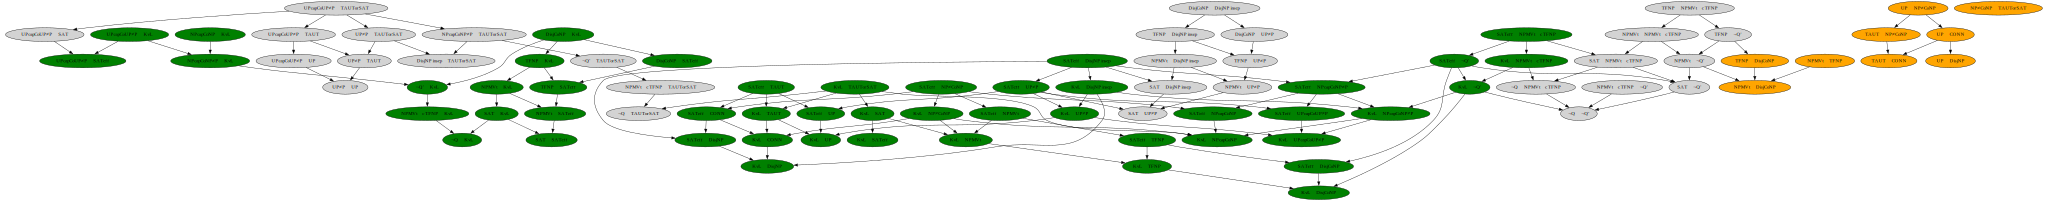

In [45]:
hard = [('negQ', "negQ'")]
new = ['SelfRed', 'KvL', 'SATeff']
original = ['CONN',
 'DisjCoNP',
 'DisjNP',
 'NPMVt',
 'NPcapCoNP',
 'NPneqCoNP',
 'PneqNP',
 'SAT',
 'TAUT',
 'TAUTorSAT',
 'TFNP',
 'UP']

def draw_oracle_graph(oracle_graph):
    draw_graph = nx.transitive_reduction(oracle_graph)
    for n in draw_graph.nodes:
        #if n in hard or any(x in nx.descendants(oracle_graph, n) for x in hard):
        #    draw_graph.nodes[n]['fillcolor'] = 'red'
        if len(set(n) & set(new)) > 0:
            draw_graph.nodes[n]['fillcolor'] = 'green'
        if len(set(n) & set(original)) == 2:
            draw_graph.nodes[n]['fillcolor'] = 'orange'
        draw_graph.nodes[n]['style'] = 'filled'
    
    for a, b in draw_graph.nodes:
        draw_graph.nodes[(a,b)]['label'] = f'{a} ⇏ {b}'.replace('insep', ' insep').replace('notcontainedin', ' ⊈c ').replace('neq', '≠').replace('neg', '¬')

    return draw_graph

draw(draw_oracle_graph(oracle_graph))

In [30]:
set(itertools.chain.from_iterable(stages)) & {'A', 'B'}

set()

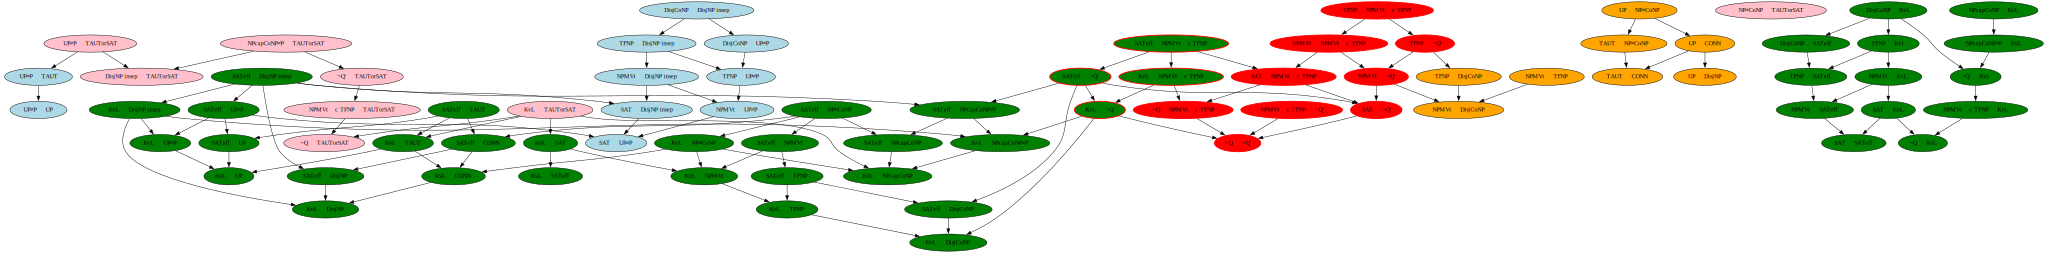

In [46]:
stages = []
stages.append(['TAUT', 'CONN', 'DisjNP', 'UP', 'SAT', 'NPMVt', 'TFNP', 'DisjCoNP', 'NPcapCoNP', 'NPneqCoNP', 'NPcapCoNPneqP'])
stages.append(['negQ', 'negQ\'', 'NPMVtnotcontainedinTFNP'])
stages.append(['UPneqP', 'DisjNPinsep'])
stages.append(['KvL', 'SATeff'])
stages.append(['TAUTorSAT',])

colors = ['orange', 'red', 'lightblue', 'green', 'pink']

draw_graph = nx.transitive_reduction(oracle_graph)
draw_graph.remove_nodes_from([ n for n in draw_graph.nodes if not set(n) <= set(itertools.chain.from_iterable(stages))]) 
for n in draw_graph.nodes:
    for i in range(len(stages)-1, 0, -1):
        if set(n) <= set(itertools.chain.from_iterable(stages[:i+1])):
            draw_graph.nodes[n]['fillcolor'] = colors[i]
    if len(set(n) & set(stages[0])) == 2:
        draw_graph.nodes[n]['fillcolor'] = colors[0]
    draw_graph.nodes[n]['style'] = 'filled'

    if n in hard or any(x in nx.descendants(oracle_graph, n) for x in hard):
        draw_graph.nodes[n]['color'] = 'red'
        draw_graph.nodes[n]['penwidth'] = 2

for a, b in draw_graph.nodes:
    draw_graph.nodes[(a,b)]['label'] = f'{a} ⇏ {b}'.replace('insep', ' insep').replace('notcontainedin', ' ⊈c ').replace('neq', '≠').replace('neg', '¬')

draw(draw_graph)

## Tabelle

In [13]:
implications.nodes

NodeView(('DisjNP', 'CONN', 'DisjNPinsep', 'TAUT', 'NPneqCoNP', 'PneqNP', 'TAUTorSAT', 'UP', 'UPneqP', 'UPcapCoUPneqP', 'NPcapCoNPneqP', "negQ'", 'NPMVtnotcontainedinTFNP', 'negQ', 'NPcapCoNP', 'DisjCoNP', 'TFNP', 'NPMVt', 'SAT', 'KvL', 'SATeff'))

In [14]:
conjectures = ['TAUT', 'CONN', 'DisjNP', 'UP', 'SAT', 'NPMVt', 'TFNP', 'DisjCoNP', 'NPcapCoNP', 'NPneqCoNP', 'NPcapCoNPneqP']
conjectures.extend(['negQ', 'negQ\'', 'NPMVtnotcontainedinTFNP'])
conjectures.extend(['UPneqP', 'DisjNPinsep'])
conjectures.extend(['KvL', 'SATeff'])
conjectures.extend(['TAUTorSAT',])# 'PneqNP'])


def custom_sort(item):
    if item.startswith('(') and item.endswith(')'):
        return (0, int(item[1:-1]))
    else:
        return (1, int(item))

df = pandas.DataFrame(index=conjectures, columns=conjectures)
df[:] = '?'

for a, b in itertools.product(conjectures, repeat=2):
    if b in nx.descendants(implications, a) or a == b:
        df.loc[a,b] = ' '

    if (a,b) in oracle_set:
        if len(set(oracle_set_labels[(a,b)])) == 1:
            df.loc[a,b] = oracle_set_labels[(a,b)][0]
        elif len(set(oracle_set_labels[(a,b)])&{'O', '(O)'}) > 0:
            df.loc[a,b] = next(iter(set(oracle_set_labels[(a,b)]) & {'O', '(O)'}))
        else:
            df.loc[a,b] = list(sorted(set(oracle_set_labels[(a,b)]), key=custom_sort))[0]

    if (a,b) in oracle_graph.nodes and ((a,b)==('negQ', 'negQ\'') or ('negQ', 'negQ\'') in nx.descendants(oracle_graph, (a,b))):
        df.loc[a,b] = '?!'

    if (a,b) in nx.descendants(oracle_graph, ('DisjCoNP', 'DisjNPinsep')):# or (a,b) in nx.descendants(oracle_graph, ('CONN', 'DisjNPinsep')):
        df.loc[a,b] = '(?)'

df

,TAUT,CONN,DisjNP,UP,SAT,NPMVt,TFNP,DisjCoNP,NPcapCoNP,NPneqCoNP,NPcapCoNPneqP,negQ,negQ',NPMVtnotcontainedinTFNP,UPneqP,DisjNPinsep,KvL,SATeff,TAUTorSAT
TAUT,,?,(13),(4),(O),(O),(O),(O),(O),?,(O),(O),(O),(O),(4),(13),(O),(O),
CONN,,,(13),(4),(O),(O),(O),(O),(O),,(O),(O),(O),(O),(4),13,(O),(O),
DisjNP,,,,(4),(O),(O),(O),(O),(O),,(O),O,(O),(O),4,,(O),(O),
UP,,?,?,,(O),(O),(O),(O),(O),?,(O),O,(O),(O),,,(O),(O),
SAT,(10),(10),(10),(10),,(12),(12),(12),(3),12,(3),,?!,?!,(?),(?),?,?,
NPMVt,(10),(10),(10),(10),,,?,?,(3),,(3),,?!,?!,(?),(?),?,?,
TFNP,(10),(10),(10),(10),,,,?,(3),,(3),,?!,?!,(?),(?),?,?,
DisjCoNP,10,(10),(10),(10),,,,,(3),,3,,,,(?),?,?,?,
NPcapCoNP,6,(6),(6),(4),5,(5),(5),(5),,,,,,,4,,?,(5),
NPneqCoNP,(6),(6),(6),(4),(O),(O),(O),(O),(O),,(O),(O),(O),(O),(4),(13),(O),(O),?


In [15]:
labeling = {'TAUT': '$\\hTAUT$', 
            'CONN': '$\\mathsf{CON^N}$', 
            'DisjNP': '$\\hDisjNP$', 
            'UP': '$\\hUP$', 
            'SAT': '$\\hSAT$', 
            'TFNP': '$\\hTFNP$',
            'NPMVt': '$\\NPMVt$ unvollst.', 
            'DisjCoNP': '$\\hDisjCoNP$', 
            'NPcapCoNP': '$\\NPcoNP$', 
            'NPneqCoNP': '$\\NP\\neq\\coNP$', 
            'NPcapCoNPneqP': '$\\NP\\cap\\coNP\\neq\\P$',
            'negQ': '$\\neg\\hQ$',
            'negQ\'': '$\\neg\\hQ\'$',
            'NPMVtnotcontainedinTFNP': '$\\NPMVt\\not\\subseteq_{\\mathrm{t}}\\TFNP$',
            'UPneqP': '$\\UP\\neq\\P$',
            'DisjNPinsep': '$\\DisjNP$ unsep.',
            'KvL': '$\\mathsf{KvL}$',
            'SATeff': '$\\mathsf{SAT^{eff}}$',
            'TAUTorSAT': '$\\hTAUT\\lor\\hSAT$',
            'PneqNP': '$\\P\\neq\\NP$'}

df2 = df.rename(index=labeling, columns=lambda x: '\\rot{' + labeling[x] + '}')\
    .map(lambda x: x if x.strip() == '' else 
         '$\\ast$' if x == '*' else
         '\\textcolor{red}{\\textbf{\\dag}}' if x == '?!' else 
         '\\textcolor{red}{\\textbf{?}}' if x in {'?', '(?)', '?!'} else
         x[1:-1] if x.startswith('(') else
        f'\\textbf{{\\itshape {x}}}' if x not in {'*', '?!'} else x)

print(df2.to_latex(escape=False))

\begin{tabular}{llllllllllllllllllll}
\toprule
 & \rot{$\hTAUT$} & \rot{$\mathsf{CON^N}$} & \rot{$\hDisjNP$} & \rot{$\hUP$} & \rot{$\hSAT$} & \rot{$\NPMVt$ unvollst.} & \rot{$\hTFNP$} & \rot{$\hDisjCoNP$} & \rot{$\NPcoNP$} & \rot{$\NP\neq\coNP$} & \rot{$\NP\cap\coNP\neq\P$} & \rot{$\neg\hQ$} & \rot{$\neg\hQ'$} & \rot{$\NPMVt\not\subseteq_{\mathrm{t}}\TFNP$} & \rot{$\UP\neq\P$} & \rot{$\DisjNP$ unsep.} & \rot{$\mathsf{KvL}$} & \rot{$\mathsf{SAT^{eff}}$} & \rot{$\hTAUT\lor\hSAT$} \\
\midrule
$\hTAUT$ &   & \textcolor{red}{\textbf{?}} & 13 & 4 & O & O & O & O & O & \textcolor{red}{\textbf{?}} & O & O & O & O & 4 & 13 & O & O &   \\
$\mathsf{CON^N}$ &   &   & 13 & 4 & O & O & O & O & O &   & O & O & O & O & 4 & \textbf{\itshape 13} & O & O &   \\
$\hDisjNP$ &   &   &   & 4 & O & O & O & O & O &   & O & \textbf{\itshape O} & O & O & \textbf{\itshape 4} &   & O & O &   \\
$\hUP$ &   & \textcolor{red}{\textbf{?}} & \textcolor{red}{\textbf{?}} &   & O & O & O & O & O & \textcolor{red}{\textbf{

## Unabhängigkeit von Q

In [16]:
conjectures = ['TAUT', 'CONN', 'DisjNP', 'UP', 'SAT', 'NPMVt', 'TFNP', 'DisjCoNP']

# case 1: not A and Q -> BGS
# case 2: A and not Q -> EEG
# case 3: not A and not Q
for a in conjectures:
    if ('negQ', a) not in oracle_set:
        print(f'oracle missing for neg({a}) and negQ')
# case 4: A and Q:
for a in conjectures:
    if (a, 'negQ') not in oracle_set:
        print(f'oracle missing for {a} and Q')

oracle missing for SAT and Q
oracle missing for NPMVt and Q
oracle missing for TFNP and Q
oracle missing for DisjCoNP and Q
